# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

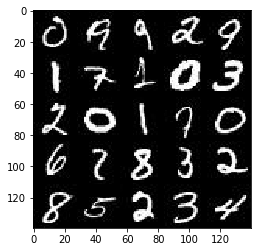

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

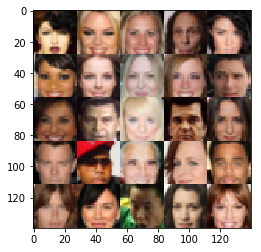

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [52]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.1
    keep_prob=0.5
    init=tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Conv one: Convolutoin, leaky relu (28x28x3 -> 14x14x64)
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=init)        
        h1 = tf.maximum(alpha * h1, h1)
        
        # Conv two: convolution, batch norm, leaky relu (-> 7x7x64)
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same', kernel_initializer=init)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.contrib.layers.dropout(h2, keep_prob)
        
        # Conv three: convolution, batch norm, leaky relu, dropout
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same', kernel_initializer=init)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.contrib.layers.dropout(h3, keep_prob)
        
        shape = h3.get_shape().as_list()
        flat = tf.reshape(h3, shape=[-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [53]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_prob=0.5
    init=tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First dense hidden layer, reshape, batch normalization, relu (7, 7, 256)
        h1 = tf.layers.dense(inputs=z, units= 7 * 7 * 256)
        h1 = tf.reshape(tensor=h1, shape=(-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(inputs=h1, training=is_train)
        h1 = tf.nn.relu(h1)

        # First convolutional hidden layer, batch normalization, relu (14, 14, 128)
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=2, padding='same', kernel_initializer=init)
        h2 = tf.layers.batch_normalization(inputs=h2, training=is_train)
        h2 = tf.nn.relu(h2)

        # Second convolutional hidden layer, batch normalization, relu (28, 28, 64)
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, padding='same', kernel_initializer=init)
        h3 = tf.layers.batch_normalization(inputs=h3, training=is_train)
        h3 = tf.nn.relu(h3)
        h3 = tf.contrib.layers.dropout(h3, keep_prob, is_training=is_train)
        
        # Third convolutional layer and output (28, 28, 64)
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=init)
        out = tf.tanh(logits)     
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    # Create GANs
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                           labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                           labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    steps = 0
    
    samples, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.7738
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 1.2478
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.3288
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 1.2249
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 2.0124... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 1.1320
Epoch 1/2... Discriminator Loss: 1.8304... Generator Loss: 0.7883


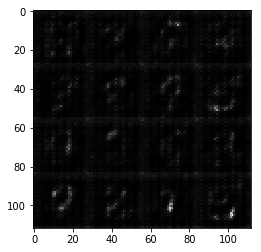

Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 1.0248
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 1.4336
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 1.2747
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 1.5071
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.5888
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.9574


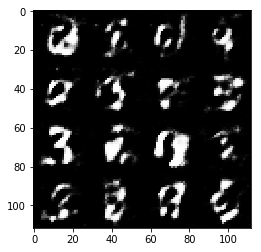

Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 1.4571
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 1.8094... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 1.4915
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 1.6252... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.9565... Generator Loss: 1.6159
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 1.6389
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 1.2890


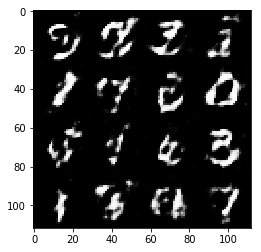

Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 1.2297
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 1.7831
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 1.8388
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 1.1978
Epoch 1/2... Discriminator Loss: 1.6827... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.5554... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 1.3149
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 1.1166


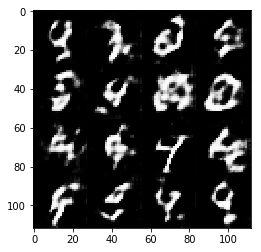

Epoch 1/2... Discriminator Loss: 1.5471... Generator Loss: 1.2887
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 1.5003
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 1.3334
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 1.2252
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 1.5909


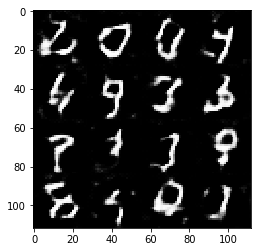

Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 1.5718
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 1.4612
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 1.5101
Epoch 1/2... Discriminator Loss: 1.4954... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.7325... Generator Loss: 0.6000


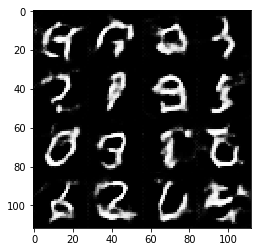

Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 1.4672
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.5901... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.5894


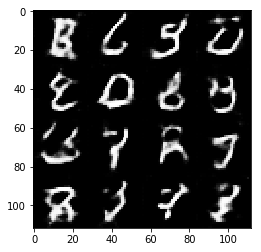

Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.6485
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 1.1826
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.8592


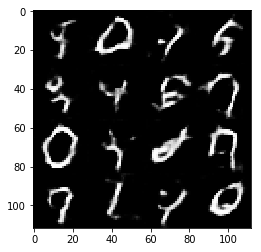

Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 1.7376... Generator Loss: 0.9498
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.8069
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.7793... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.9528


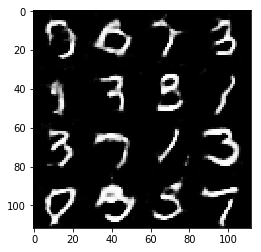

Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 1.1033
Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.5399... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.8489


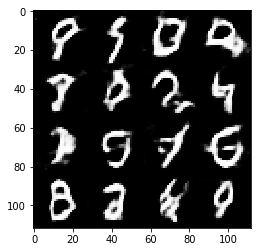

Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 1.0683
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.8759


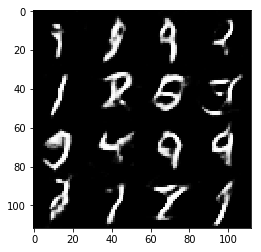

Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 1.5156... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 1.2181


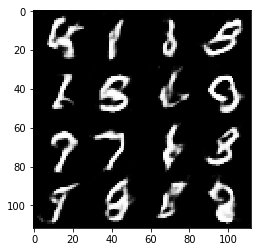

Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 1.1385
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.8893


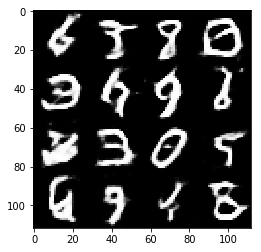

Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.8282
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.9785
Epoch 1/2... Discriminator Loss: 1.8024... Generator Loss: 0.6328


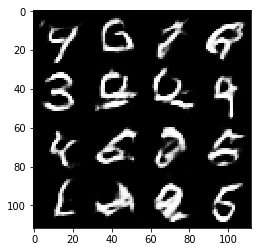

Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.5535... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.9866


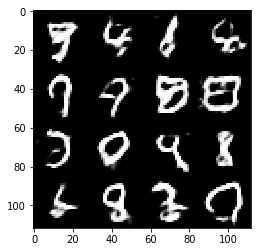

Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 1.3084
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.8891


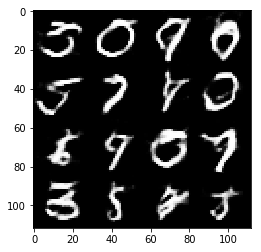

Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7488


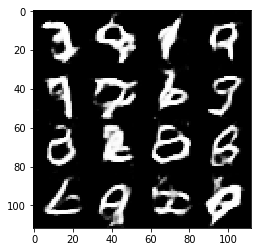

Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.8954


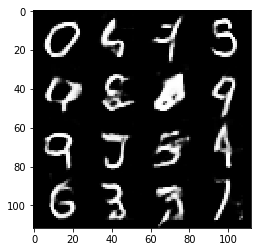

Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.7934


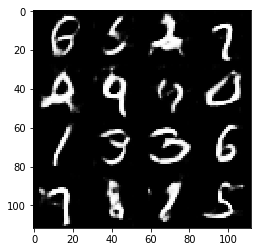

Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 1.0992
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.5820... Generator Loss: 1.1641
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.9083


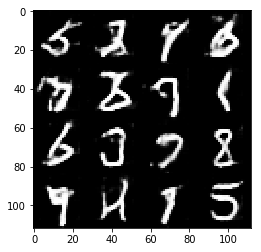

Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.5977... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.9744


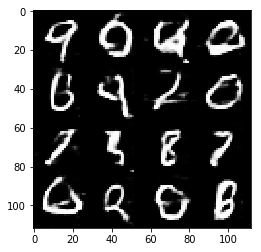

Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.7134
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.8866
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 1.1090
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.7654


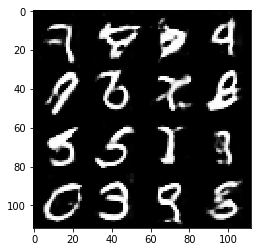

Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 1.1977


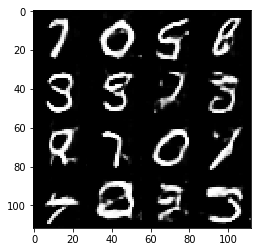

Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 1.1244
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.9060


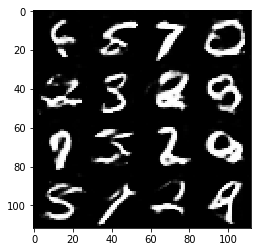

Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.5155... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.8249


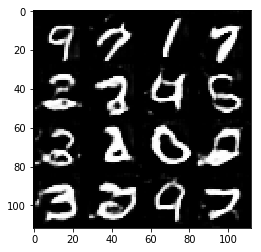

Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.6478


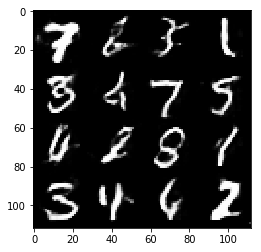

Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 1.0663
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 1.5470... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.7758


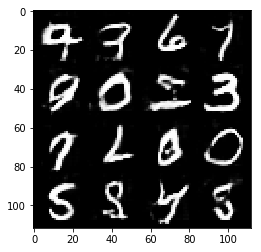

Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 1.4731... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 1.0943
Epoch 2/2... Discriminator Loss: 1.6218... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.8959


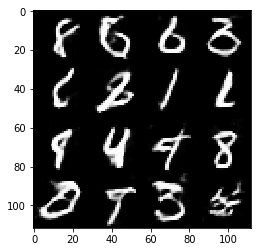

Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.4549... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.7363


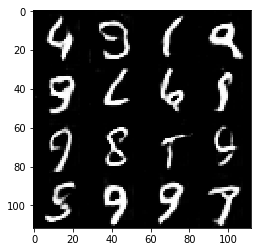

Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.6264... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.5578... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.8896
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 1.4584... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.7266


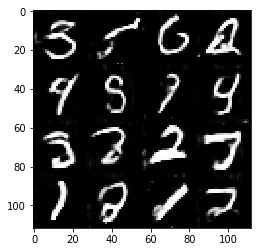

Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.5156... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 0.6408


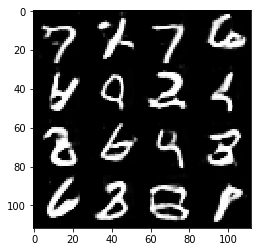

Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.6096
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 1.0416


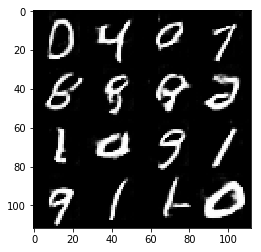

Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 1.0581
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6181
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.8839


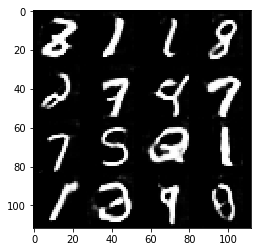

Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 1.0587


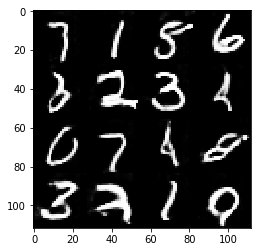

Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 1.5413... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.9737


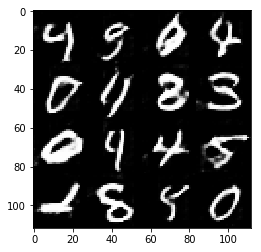

Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 1.5132... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.8299


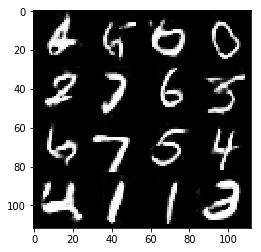

Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 1.0246
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.6681


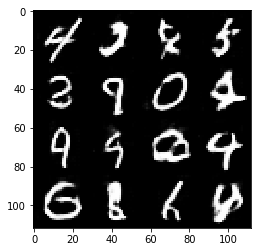

Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 1.0160


In [58]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.7526
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.1312
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 2.5688
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.6969
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 2.8054
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 2.1374
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 3.1738
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 3.4250


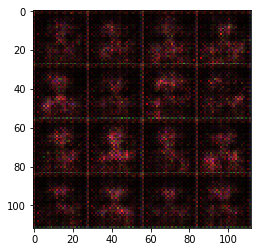

Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 2.8794
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 2.0444
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 3.2703
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 3.0336
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 2.7667
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 2.6767
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 2.2820
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 2.7755


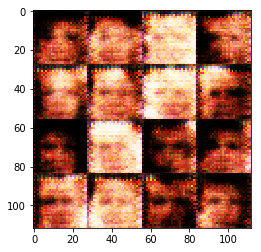

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.5054
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 2.6856
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 2.6723
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.9190
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 3.6680
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 3.2377
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 3.7014
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 2.0979


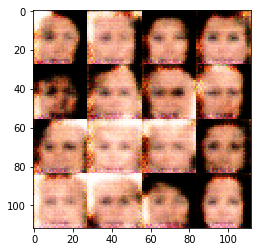

Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 2.0529
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.8085
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 2.1608
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 2.2102
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.6702
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.7558
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 4.0556
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 3.7653


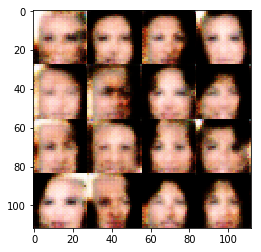

Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.8327
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 3.4843
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 2.5660
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 2.3540
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 3.2955
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.7498
Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 2.0969
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.0484


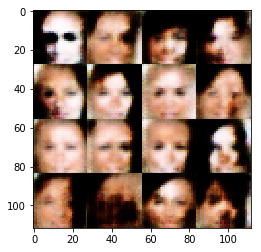

Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.8742
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 3.0079
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 2.6266
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 2.3598
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 2.3464
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 2.4351


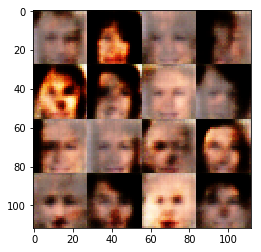

Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 2.1099
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 2.3099
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 2.5170
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 3.1626
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.5488


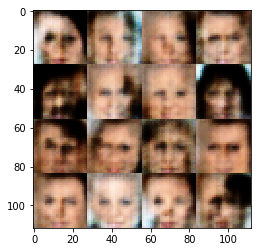

Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 3.1720
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.4026


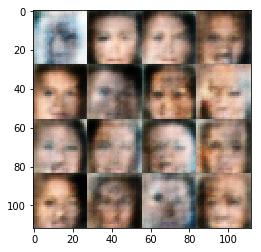

Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.5105
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 1.4369
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 1.1630


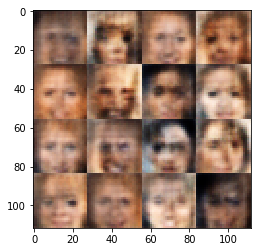

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.6742
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.1043


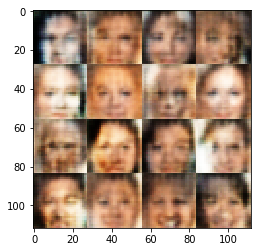

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9200


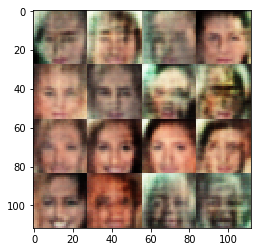

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7348


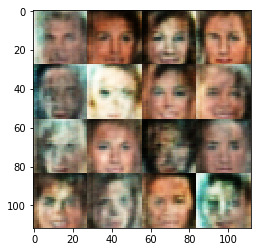

Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.9356


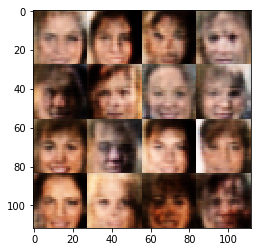

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.0347


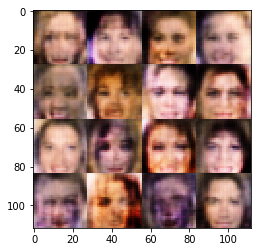

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 1.1475


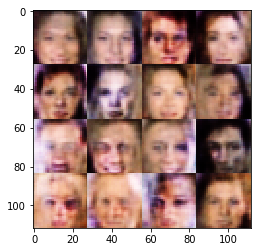

Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.0182


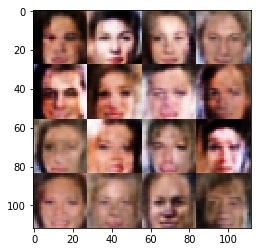

Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.9094


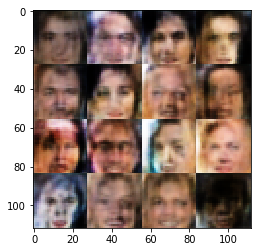

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.9929


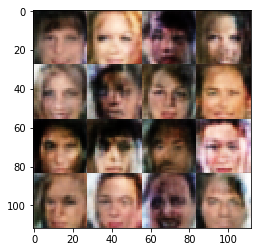

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8046


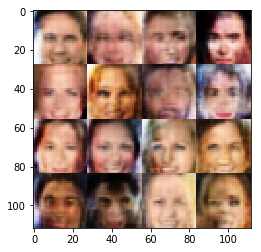

Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8794


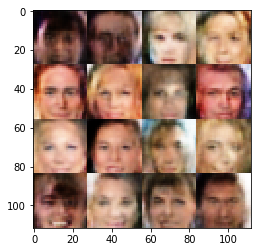

Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8463


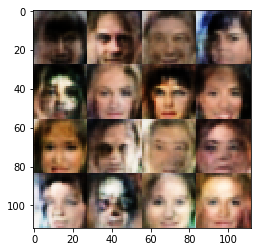

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7990


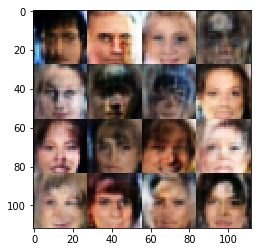

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.0801


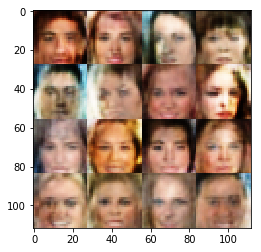

Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8891


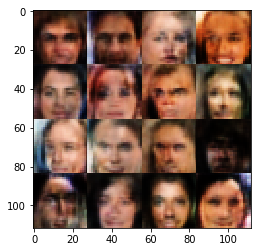

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9010


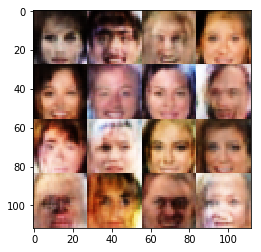

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.9657


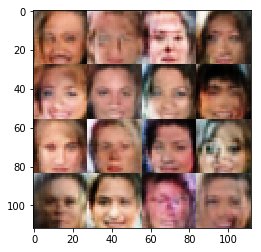

Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9640


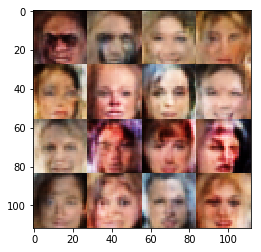

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9312


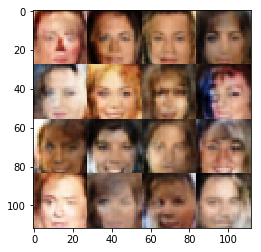

Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.9537


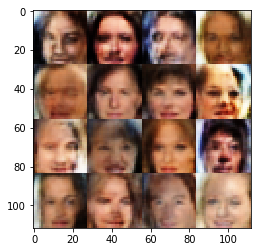

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7851


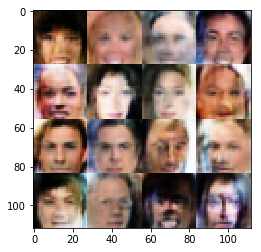

Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8302


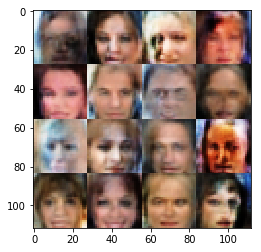

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9174


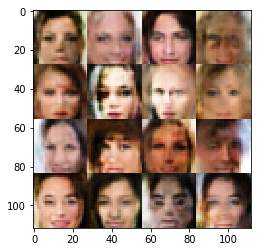

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8395


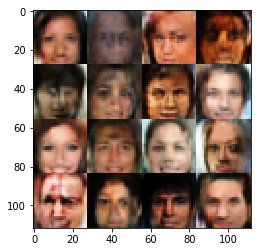

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8134


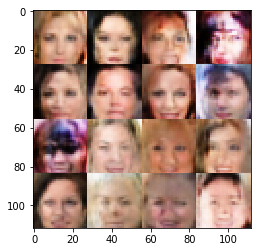

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7062


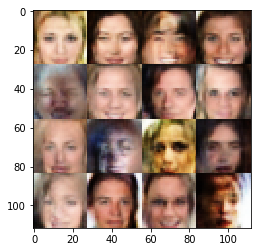

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7932


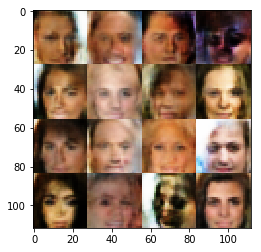

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6775


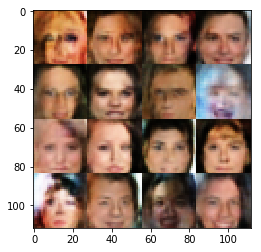

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.8021


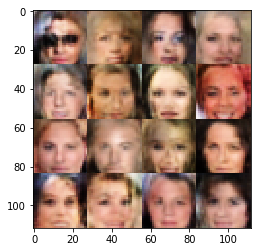

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8129


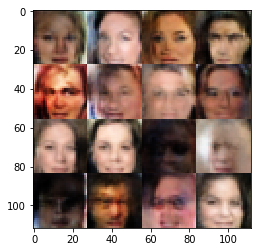

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8646


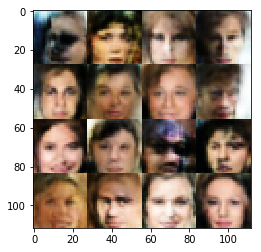

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.8412


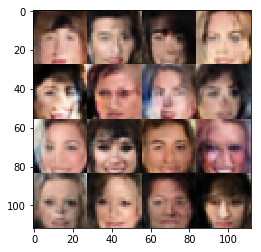

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.9728


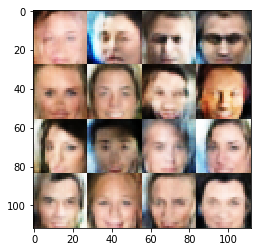

Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8200


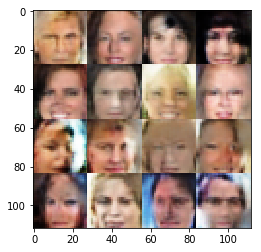

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.9254


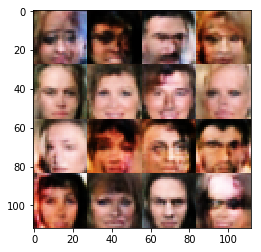

Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8368


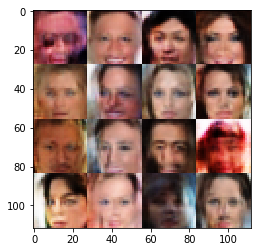

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7359


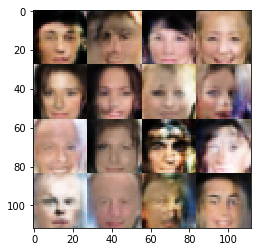

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8429


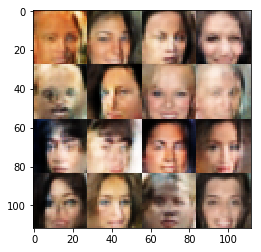

Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8210


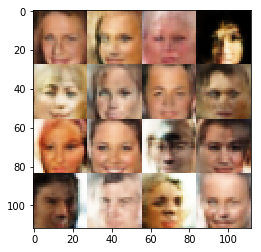

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.9051


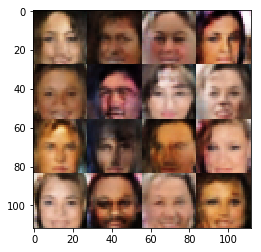

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7534


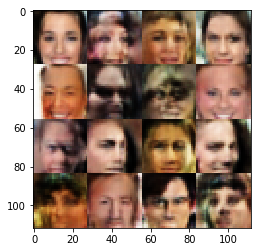

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8256


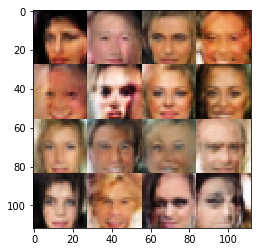

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7285


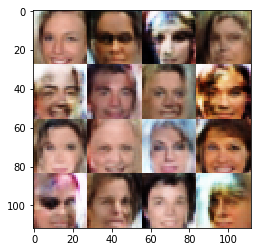

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.8494


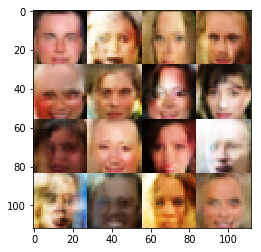

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7718


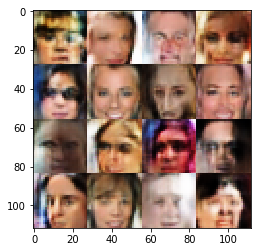

Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7654


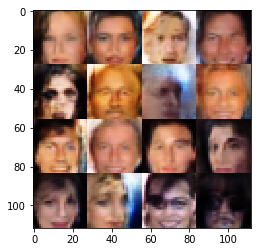

Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8733


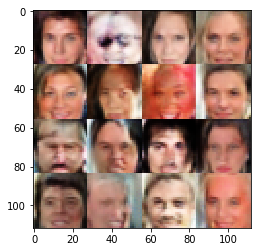

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.8207


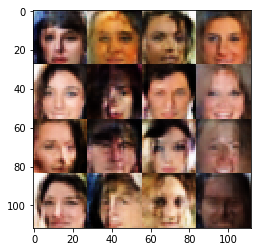

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8063


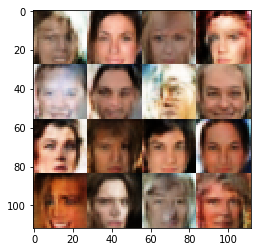

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.8170


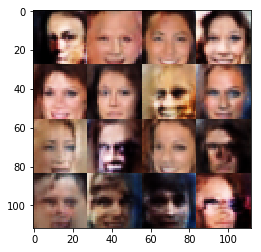

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7552


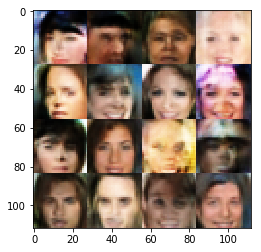

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7754


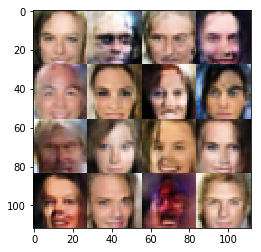

Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7973


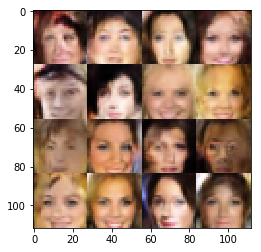

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8389


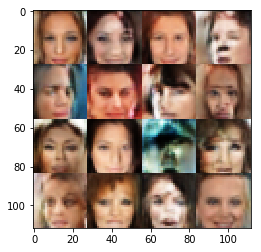

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7851


In [59]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.